In [76]:
# Please install packages if you don't have them
import numpy as np
import cv2
import matplotlib.pyplot as plt
import nanonispy as nap
from scipy.ndimage import center_of_mass
from scipy.ndimage import mean
import copy
import math
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

In [77]:
def subtractMeanPlane(matrix): 
    xdim,ydim = matrix.shape
    coordMatrix = np.zeros((xdim*ydim,3))
    zVector = np.zeros(xdim*ydim)
    for i in range(xdim):
        for j in range(ydim):
            coordMatrix[i*xdim+j] = [i,j,1]
            zVector[i*xdim+j] = matrix[i,j]
        
    zVector = np.matrix(zVector)
    coordMatrix = np.matrix(coordMatrix)
    planeVector = (coordMatrix.T * coordMatrix).I * coordMatrix.T * zVector.T
    planeMatrix = np.zeros((xdim,ydim)) 

    for i in range(xdim):
        for j in range(ydim): 
            planeMatrix[i,j] = i*planeVector[0]+j*planeVector[1]+planeVector[2]
    
    return(np.subtract(matrix,planeMatrix))

def ims(img):
    plt.figure(figsize=(8,8))
    plt.imshow(img,origin='upper')
    plt.colorbar()
    plt.show()
    
def dcopy(a):
    return copy.deepcopy(a)

# returns the 2r * 2r square centered at topo[x,y]
def squarec10(topo):
    n = topo.shape[0]
    return square10(topo,n/2,n/2)
def square10(topo,x,y):
    return topo[x-10:x+10,y-10:y+10]
def square_vec10(topo,v):
    return topo[v[0]-10:v[0]+10,v[1]-10:v[1]+10]
def square_vec_r(topo,v,r):
    return topo[v[0]-r:v[0]+r,v[1]-r:v[1]+r]

def czeros(N):
    return np.zeros((N,N),dtype=np.complex)

def zeros(N):
    return np.zeros((N,N),dtype=float)

pi = math.pi

In [78]:
def find_bragg(topo_fft,neighborhood_size,threshold):    
    data = abs(topo_fft)
    
    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0
    
    labeled, num_objects = ndimage.label(maxima)
    xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))
    
    plt.imshow(data)
    plt.savefig('/tmp/data.png', bbox_inches = 'tight')
    
    plt.autoscale(False)
    plt.plot(xy[:, 1], xy[:, 0], 'ro')
    plt.savefig('/tmp/result.png', bbox_inches = 'tight')
    plt.show()
    
    xy = xy.astype(int)
    return xy

def fft(topo):
    return np.fft.fftshift(np.fft.fft2(topo))

def make_continuous(map1,d):
    N = map1.shape[0]
    cor = copy.deepcopy(map1)
    
    for i in range(N):
        for j in range(N-1):
            ori = cor[i,j]
            nxt = cor[i,j+1]
            diff = nxt-ori
            if(abs(diff)>6-d):
                cor[i,j+1]=cor[i,j+1]-2*pi*np.sign(diff)
#             if(abs(diff)>3-d):
#                 cor[i,j+1]=cor[i,j+1]-pi*np.sign(diff)
    for i in range(N-1):
        for j in range(N):
            ori = cor[i,j]
            nxt = cor[i+1,j]
            diff = nxt-ori
            if(abs(diff)>6-d):
                cor[i+1,j]=cor[i+1,j]-2*pi*np.sign(diff)
#             if(abs(diff)>3-d):
#                 cor[i+1,j]=cor[i+1,j]-pi*np.sign(diff)
#     ims(cor)
    return cor

def phasemap(g1,g2,topo_fft):
    fft_g1,fft_g2 = czeros(N),czeros(N)
    fft_g1[N_2-6:N_2+6,N_2-6:N_2+6] = square_vec_r(topo_fft,g1,6)
    fft_g2[N_2-6:N_2+6,N_2-6:N_2+6] = square_vec_r(topo_fft,g2,6)
    
    ifft1=np.fft.ifft2(np.fft.ifftshift(fft_g1))
    phase_map1=np.angle(ifft1)
    ifft2=np.fft.ifft2(np.fft.ifftshift(fft_g2))
    phase_map2=np.angle(ifft2)
    return(phase_map1,phase_map2)


def displacement(g1,g2,cor1,cor2):
# constructing new g1, ux,u2 = displacement field from peak1 & peak2
    base = np.array([[N/2,N/2],
                    [N/2,N/2]])
    g = np.subtract(base,(g1,g2)) / N
    ginv = np.linalg.inv(g)
    
    pg = np.array([cor1,cor2])
    
    ux,uy = np.zeros((N,N),dtype=float),np.zeros((N,N),dtype=float)
    u = np.array([ux,uy])
    
    for i in range(N):
        for j in range(N):
            pgij = np.array([[cor1[i,j]],[cor2[i,j]]]) 
            a = - ginv @ pgij / (2*np.pi)
            ux[i][j]=a[0]
            uy[i][j]=a[1]
    
    # setting pg[N/2][N/2]=0
    ux = ux-ux[int(N/2),int(N/2)]
    uy = uy-uy[int(N/2),int(N/2)]
    
    # construct corrected map for linear map
    for i in range(N):
        for j in range(N):
            ux[i][j]=-ux[i][j]+i
            uy[i][j]=-uy[i][j]+j
    return(ux,uy)

def remapf(topo,ux,uy):
     return cv2.remap(np.float32(topo),np.float32(uy),np.float32(ux),interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)

def brag_peak_set1(xy):
    g1=sorted(xy, key=lambda x:(x[1],x[0]))[0]
    g2=sorted(xy, key=lambda x:(x[0],x[1]))[0]
    return g1,g2

def brag_peak_set2(xy):
    g1=sorted(xy, key=lambda x:(x[1],x[0]))[-1]
    g2=sorted(xy, key=lambda x:(x[0],x[1]))[-1]
    return g1,g2

def drift_correct(topo,peak_list,peak_set,neighborhood_size,threshold):
    topo_fft = fft(topo)
    if(peak_set==1):
        g1,g2 = brag_peak_set1(peak_list)
    else:
        g1,g2 = brag_peak_set2(peak_list)
    (ph1,ph2) = phasemap(g1,g2,topo_fft)
    cor1,cor2 = make_continuous(ph1,d),make_continuous(ph2,d)
    (ux,uy)=displacement(g1,g2,cor1,cor2)
    return remapf(topo,ux,uy)

# Drift correction
0. the defualt data is in STMpy/Data folder.
1. change data path
2. **Do this first !** increase threshold & neighborhood if peaks are too many (and vice versa), until farest 4 peaks looks like Bragg peak

if it doesn't work pleass email/slack Will | yixinj2@illinois.edu with sxm file.

In [97]:
# load your data
scan=nap.read.Scan("scan039_dav.sxm") # change this!

topo=scan.signals.get("Z").get("forward")
topo=subtractMeanPlane(topo)
N = topo.shape[0]
N_2 = int(N/2)
topo_fft = fft(topo)

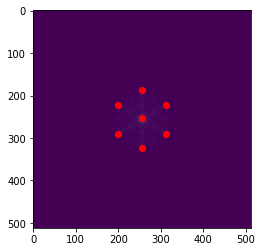

In [102]:
neighborhood_size = 10 # comparing peak to a nbor_size of nearby points

"""threshold = the difference between maximum and its neighboors,
    meaning all peaks that has difference (with its neighbors) larger than threshold will appear"""
threshold = 3e-7

# parameter for constructing phasemap [manual-3]
d = 0.4
peak_list = find_bragg(topo_fft,neighborhood_size,threshold)

<ipython-input-77-53ab53c70b1a>:42: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.zeros((N,N),dtype=np.complex)


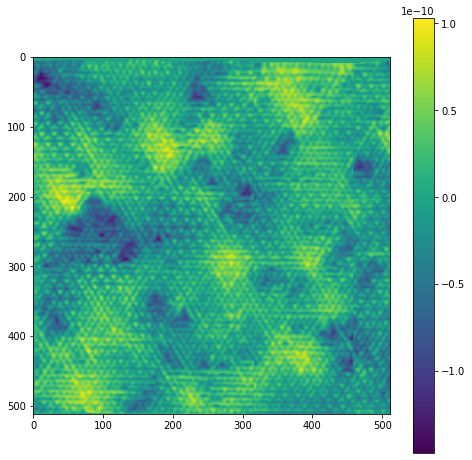

In [103]:
# two ways to correct the map
map1 = drift_correct(topo_fft,peak_list,1,neighborhood_size,threshold)
ims(map1)

<ipython-input-77-53ab53c70b1a>:42: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.zeros((N,N),dtype=np.complex)


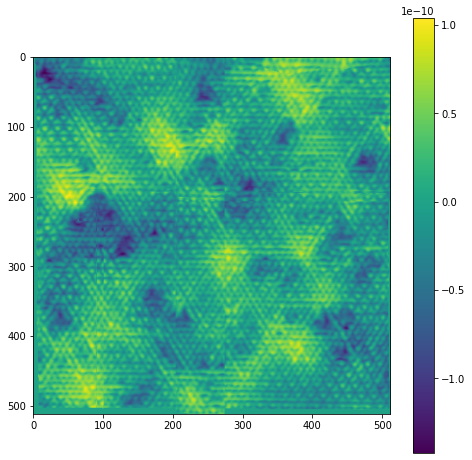

In [104]:
topo_fft = fft(topo)
map2 = drift_correct(topo_fft,peak_list,2,neighborhood_size,threshold)
ims(map2)